In [2]:
import numpy as np
import pylab as plt
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc.prior
from pyabc.plots import plot_marginals, plot_particles, plot_pairs
%matplotlib notebook

## Intractable model by Tanaka et al. 2006 for spread of tuberculosis

![](img/transmission_process.png)

### model parameter
$\alpha$: rate with which each infectious host randomly infects other individuals from an unlimited supply of hosts

$\delta$: rate with which a host stops being infectious, either by recovering or dying

$\tau$: rate with which the pathogen of the host mutates randomly within the host, generating a novel haplotype under a single-locus infinite alleles model

$\theta = (\alpha, \delta, \tau)$

$y_{\theta} = (6,3,2,2,1,1,1,1,1,1,1)$: output, vector of clusters, that is different haplotypes. Each number represents the infectious hosts for this particular haplotype

### Observation
$\alpha = 0.2, \delta = 0, \tau = 0.198, m = 20$

assume, that $\delta, \tau$ are known and apply uniform prior

In [93]:
alpha = 0.2
delta = 0
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = tuberculosis.simulator

In [91]:
min(prior_alpha.sample(10000))

array([ 0.00502157])

In [45]:
# for i in range(100):
#     params = [prior_alpha.sample(),prior_delta.sample(),prior_tau.sample()]
#     y0 = simulator(*params)

params = [alpha, tau, delta]

y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper

In [42]:
y0 = simulator(*params)
y0

array([3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [46]:
list_of_sum = tuberculosis.summaries
for f in list_of_sum:
    print(f.__name__)
    print(f(y0))
    
#summaries = tuberculosis.summaries
summaries = [lambda x: x]

T1
0.55
T2
0.85


### ABC with summary stats

In [94]:
rej = pyabc.RejectionSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337, verbosity=1)
smc = pyabc.SMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337)
mcmc = pyabc.MCMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337)
abcde = pyabc.ABCDESampler(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, seed = 1337)

In [65]:
rej.sample(nr_samples=1000, threshold=0.5)

Rejection sampler started with threshold: 0.5 and number of samples: 1000
Samples:   1000 - Threshold: 0.5000 - Iterations:     518000 - Acceptance rate: 0.001931 - Time:  2391.87 s


In [66]:
smc.sample(nr_samples=1000, thresholds=np.linspace(2, 0.5, 4))

SMC sampler started with thresholds: [ 2.   1.5  1.   0.5] and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:   1000 - Thresholds: 0.50 - Iterations:     335657 - Acceptance rate: 0.002979 - Time:  2229.74 s


In [67]:
mcmc.sample(nr_samples=1000, threshold=0.5, step_size = [0.1])

MCMC sampler started with threshold: 0.5 and number of samples: 1000
Samples:   1000 - Threshold: 0.5000 - Iterations:     162531 - Acceptance rate: 0.006153 - Time:   991.59 s


In [59]:
abcde.sample(nr_samples=100, nr_groups = 10, nr_iter = 200, burn_in = 100, alpha = 0.0, beta = 0.0, kappa = 0.9)

ABC-Differential-Evolution sampler started with number of samples: 100
initializing pools
starting iteration [ 100 ]
Samples:    100 - Iterations:        200 - Acceptance rate: None - Time:   133.57 s


<IPython.core.display.Javascript object>


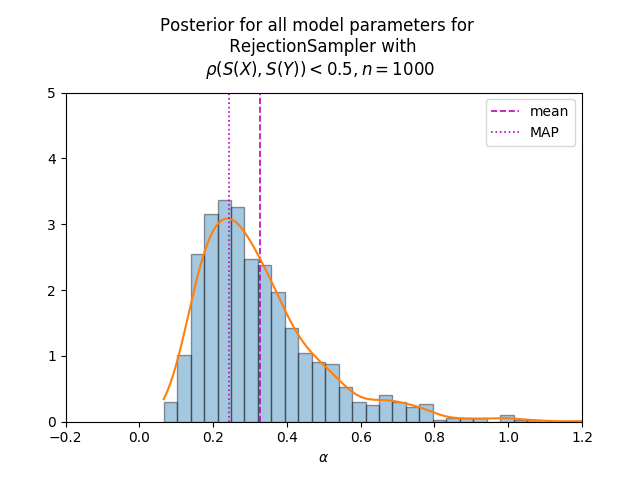

<IPython.core.display.Javascript object>


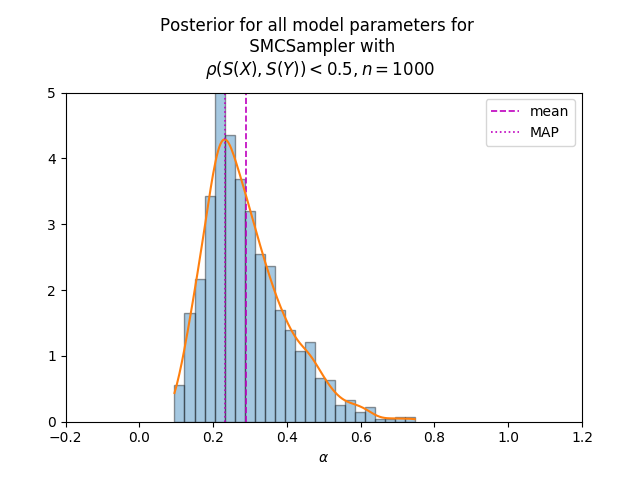

<IPython.core.display.Javascript object>


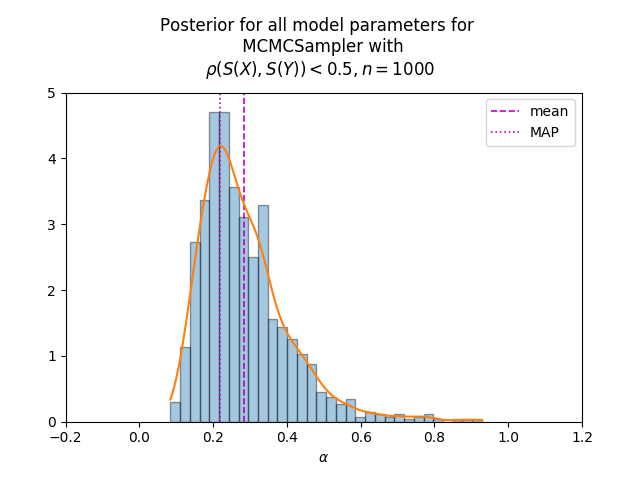

In [80]:
fig = plot_marginals(rej, kde=True, normed=True, xlim=[[-0.2, 1.2]], ylim=[0, 5])
fig = plot_marginals(smc, kde=True, normed=True, xlim=[[-0.2, 1.2]], ylim=[0, 5])
fig = plot_marginals(mcmc, kde=True, normed=True, xlim=[[-0.2, 1.2]], ylim=[0, 5])
#fig = plot_marginals(abcde, kde=True, normed=True)
#plot_marginals(bolfi, kde=True, normed=True)

<IPython.core.display.Javascript object>


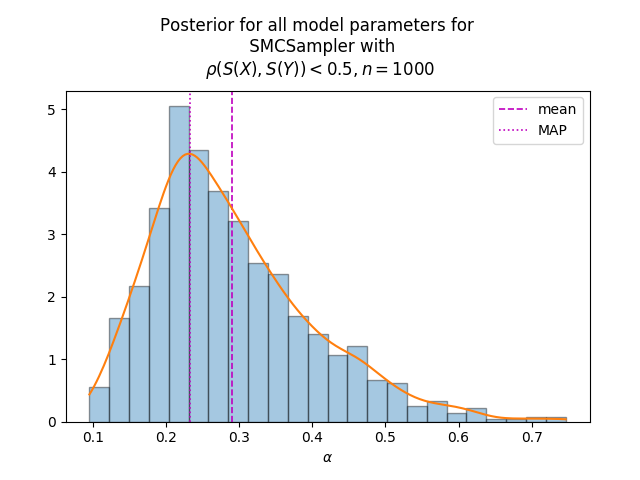

<IPython.core.display.Javascript object>


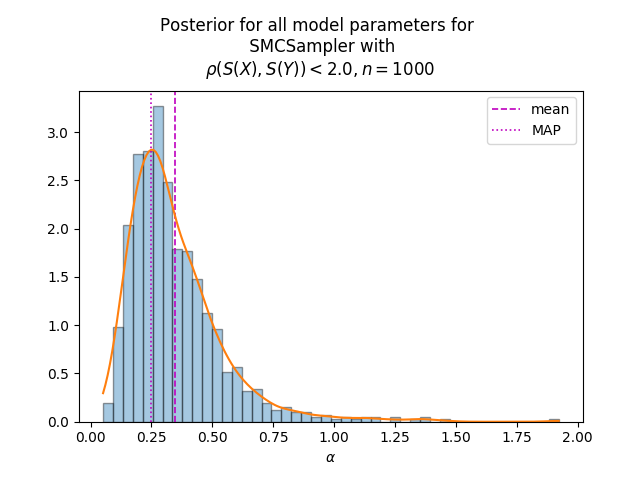

<IPython.core.display.Javascript object>


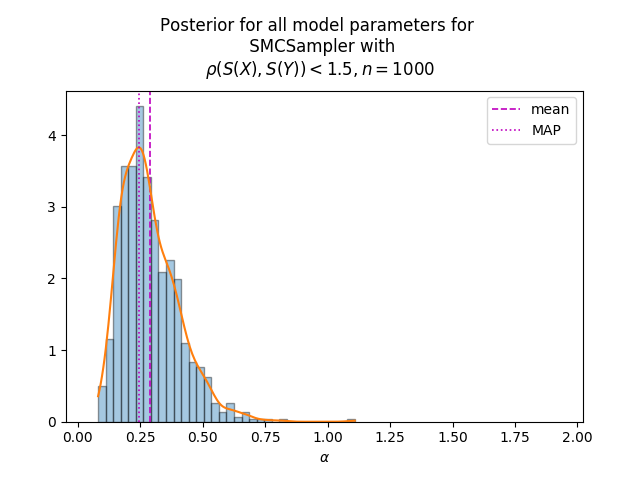

<IPython.core.display.Javascript object>


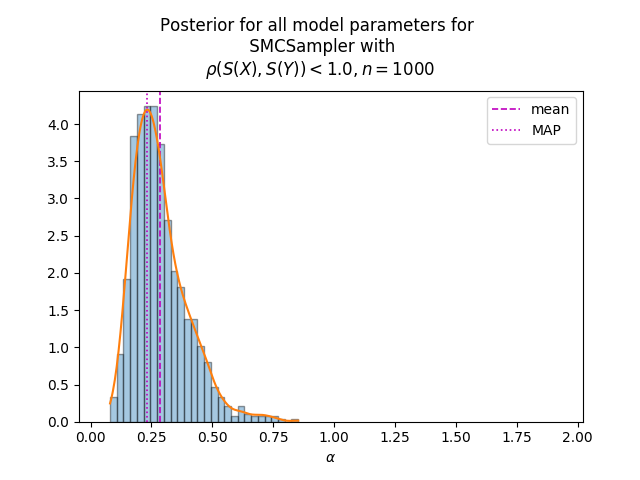

<IPython.core.display.Javascript object>


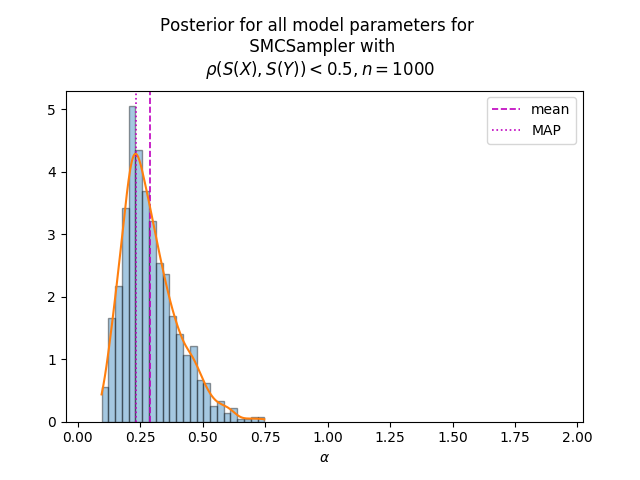

<IPython.core.display.Javascript object>


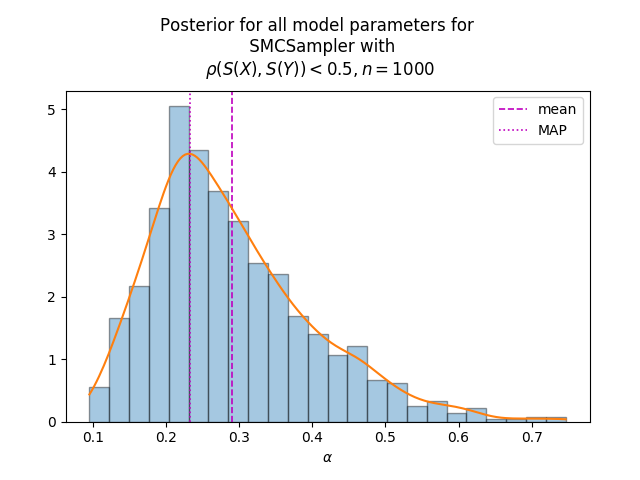

In [69]:
plot_marginals(smc, plot_all=True)

<IPython.core.display.Javascript object>


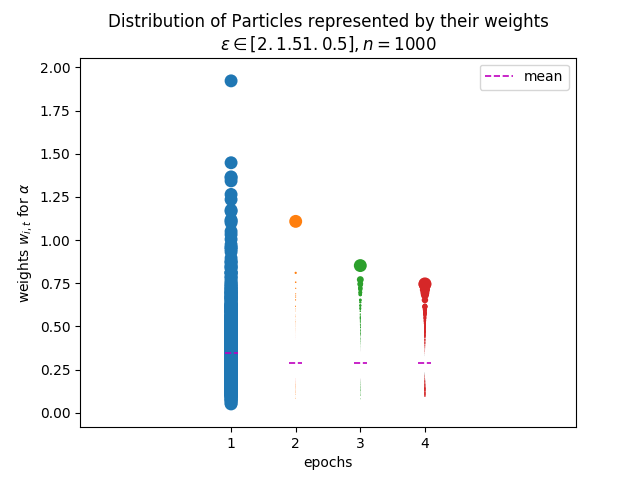

In [72]:
fig = plot_particles(smc)

## Influence of Summary Stats

In [81]:
T_1, T_2 = tuberculosis.summaries

In [82]:
T_1(y0)

0.55

In [83]:
T_2(y0)

0.84999999999999998

In [96]:
rej = pyabc.RejectionSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=[T_1],
                             observation=y0, seed = 1337, verbosity=1)
smc = pyabc.SMCSampler(priors=list_of_priors, simulator=simulator, 
                             summaries=[T_1],
                             observation=y0, seed = 1337)
mcmc = pyabc.MCMCSampler(priors=list_of_priors, simulator=simulator, 
                         summaries=[T_1], 
                         observation=y0, seed = 1337)

In [ ]:
rej.sample(nr_samples=1000, threshold=0.1)

Rejection sampler started with threshold: 0.1 and number of samples: 1000


In [ ]:
mcmc.sample(nr_samples=1000, threshold=0.5, step_size = [0.1])

<IPython.core.display.Javascript object>


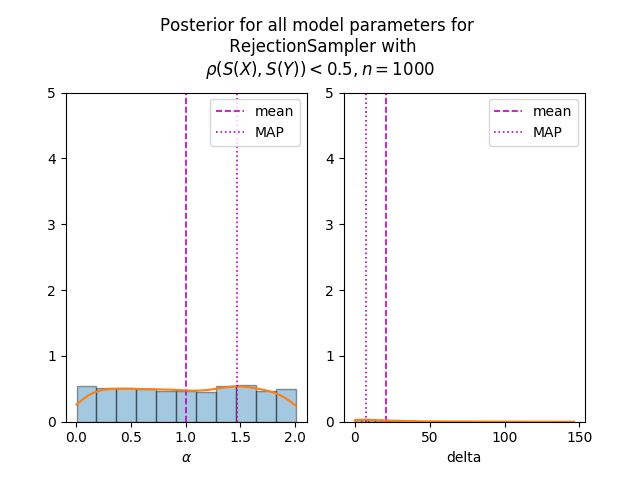

In [89]:
fig = plot_marginals(rej, kde=True, normed=True, xlim=[[-0.2, 1.2]], ylim=[0, 5])